# Setup

Importing libraries, reaading the dataframe from the excel file, setting the seed for reproducibility and setting <code>ignore warnings</code>.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

df = pd.read_excel('Needs.xls')

seed = 69

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

The first column (<code>ID</code>) is deleted, since it is useless for classification purposes.

In [2]:
df.drop(labels='ID', axis=1, inplace=True)

The dataframe is shuffled and split into samples (<code>x_df</code>) and targets (<code>y_inc_df</code> and <code>y_acc_df</code>). The target dataframes are two since two different classifiers will be used to predict <code>income investment propensity</code> and <code>accumulation investment propensity</code>.

In [3]:
df = df.sample(frac = 1, random_state = seed)

x_df = df[['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth']]
y_inc_df = df['IncomeInvestment']
y_acc_df = df['AccumulationInvestment']

The dataframes are split into training, validation and test sets (splits: $70\%$ training, $15\%$ valdation, $15\%$ test). All preprocessing parameters (e.g. $\mu$ and $\sigma$ for standardization) will be evaluated on the training set and applied to validation and test sets to prevent the introduction of bias on validation and test sets.

In [4]:
from sklearn.model_selection import train_test_split

# first split between training and validation + testing
x_train, x_val_test, y_inc_train, y_inc_val_test = train_test_split(x_df, y_inc_df, test_size=0.3, random_state=seed)
x_train, x_val_test, y_acc_train, y_acc_val_test = train_test_split(x_df, y_acc_df, test_size=0.3, random_state=seed)

# second split between validation and testing
x_val, x_test, y_inc_val, y_inc_test = train_test_split(x_val_test, y_inc_val_test, test_size=0.5, random_state=seed)
x_val, x_test, y_acc_val, y_acc_test = train_test_split(x_val_test, y_acc_val_test, test_size=0.5, random_state=seed)

# Data Exploration

Feature distributions are plotted.

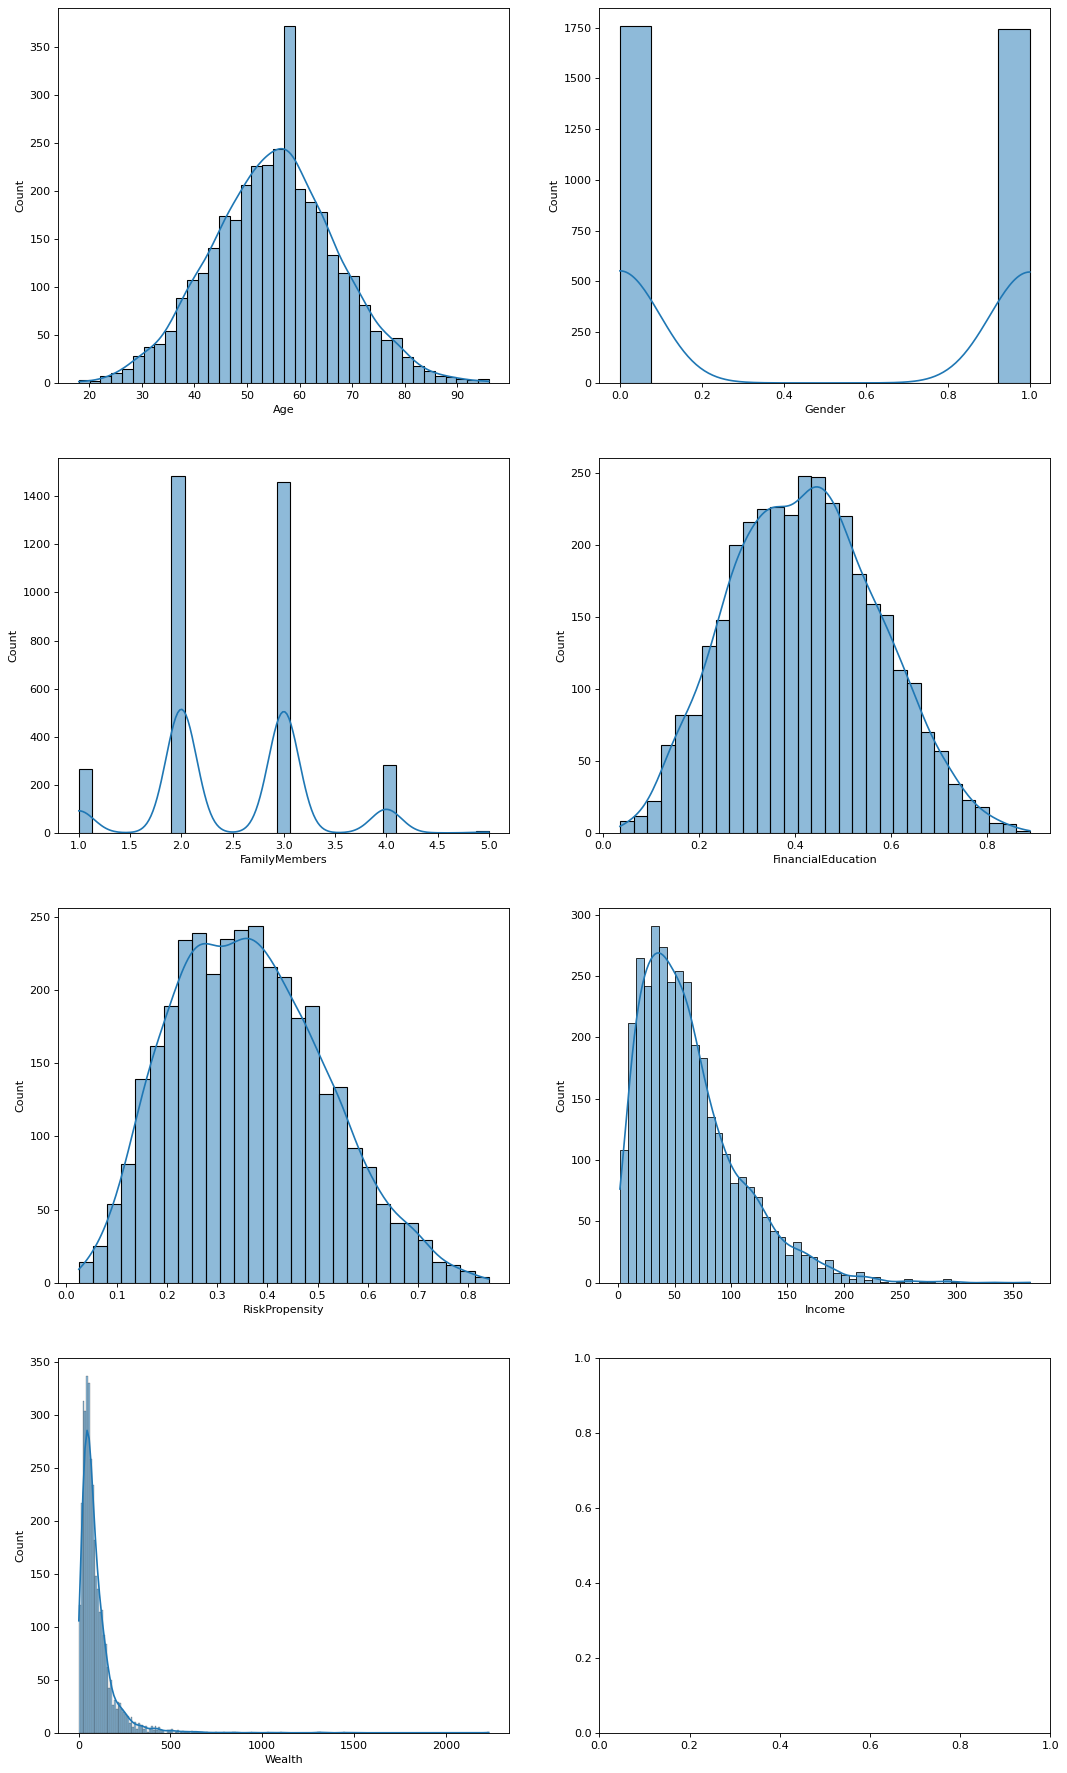

In [52]:
fig, axes = plt.subplots(4, 2, figsize=(16,28), dpi=80)
features = x_train.columns

row = column = 0

for f in features:
    ax = axes[row][column]

    sns.histplot(data=x_train, x=f, ax=ax, kde=True)

    column = column + 1
    if column % 2 == 0:
        column = 0
        row = row + 1 

The scatterplots of each feature versus the other using the labels <code>IncomeInvestment</code> and <code>AccumulationInvestment</code> as grouping variables are plotted. This is done mainly to determine whether one or more features could be considered useless for classification purposes.

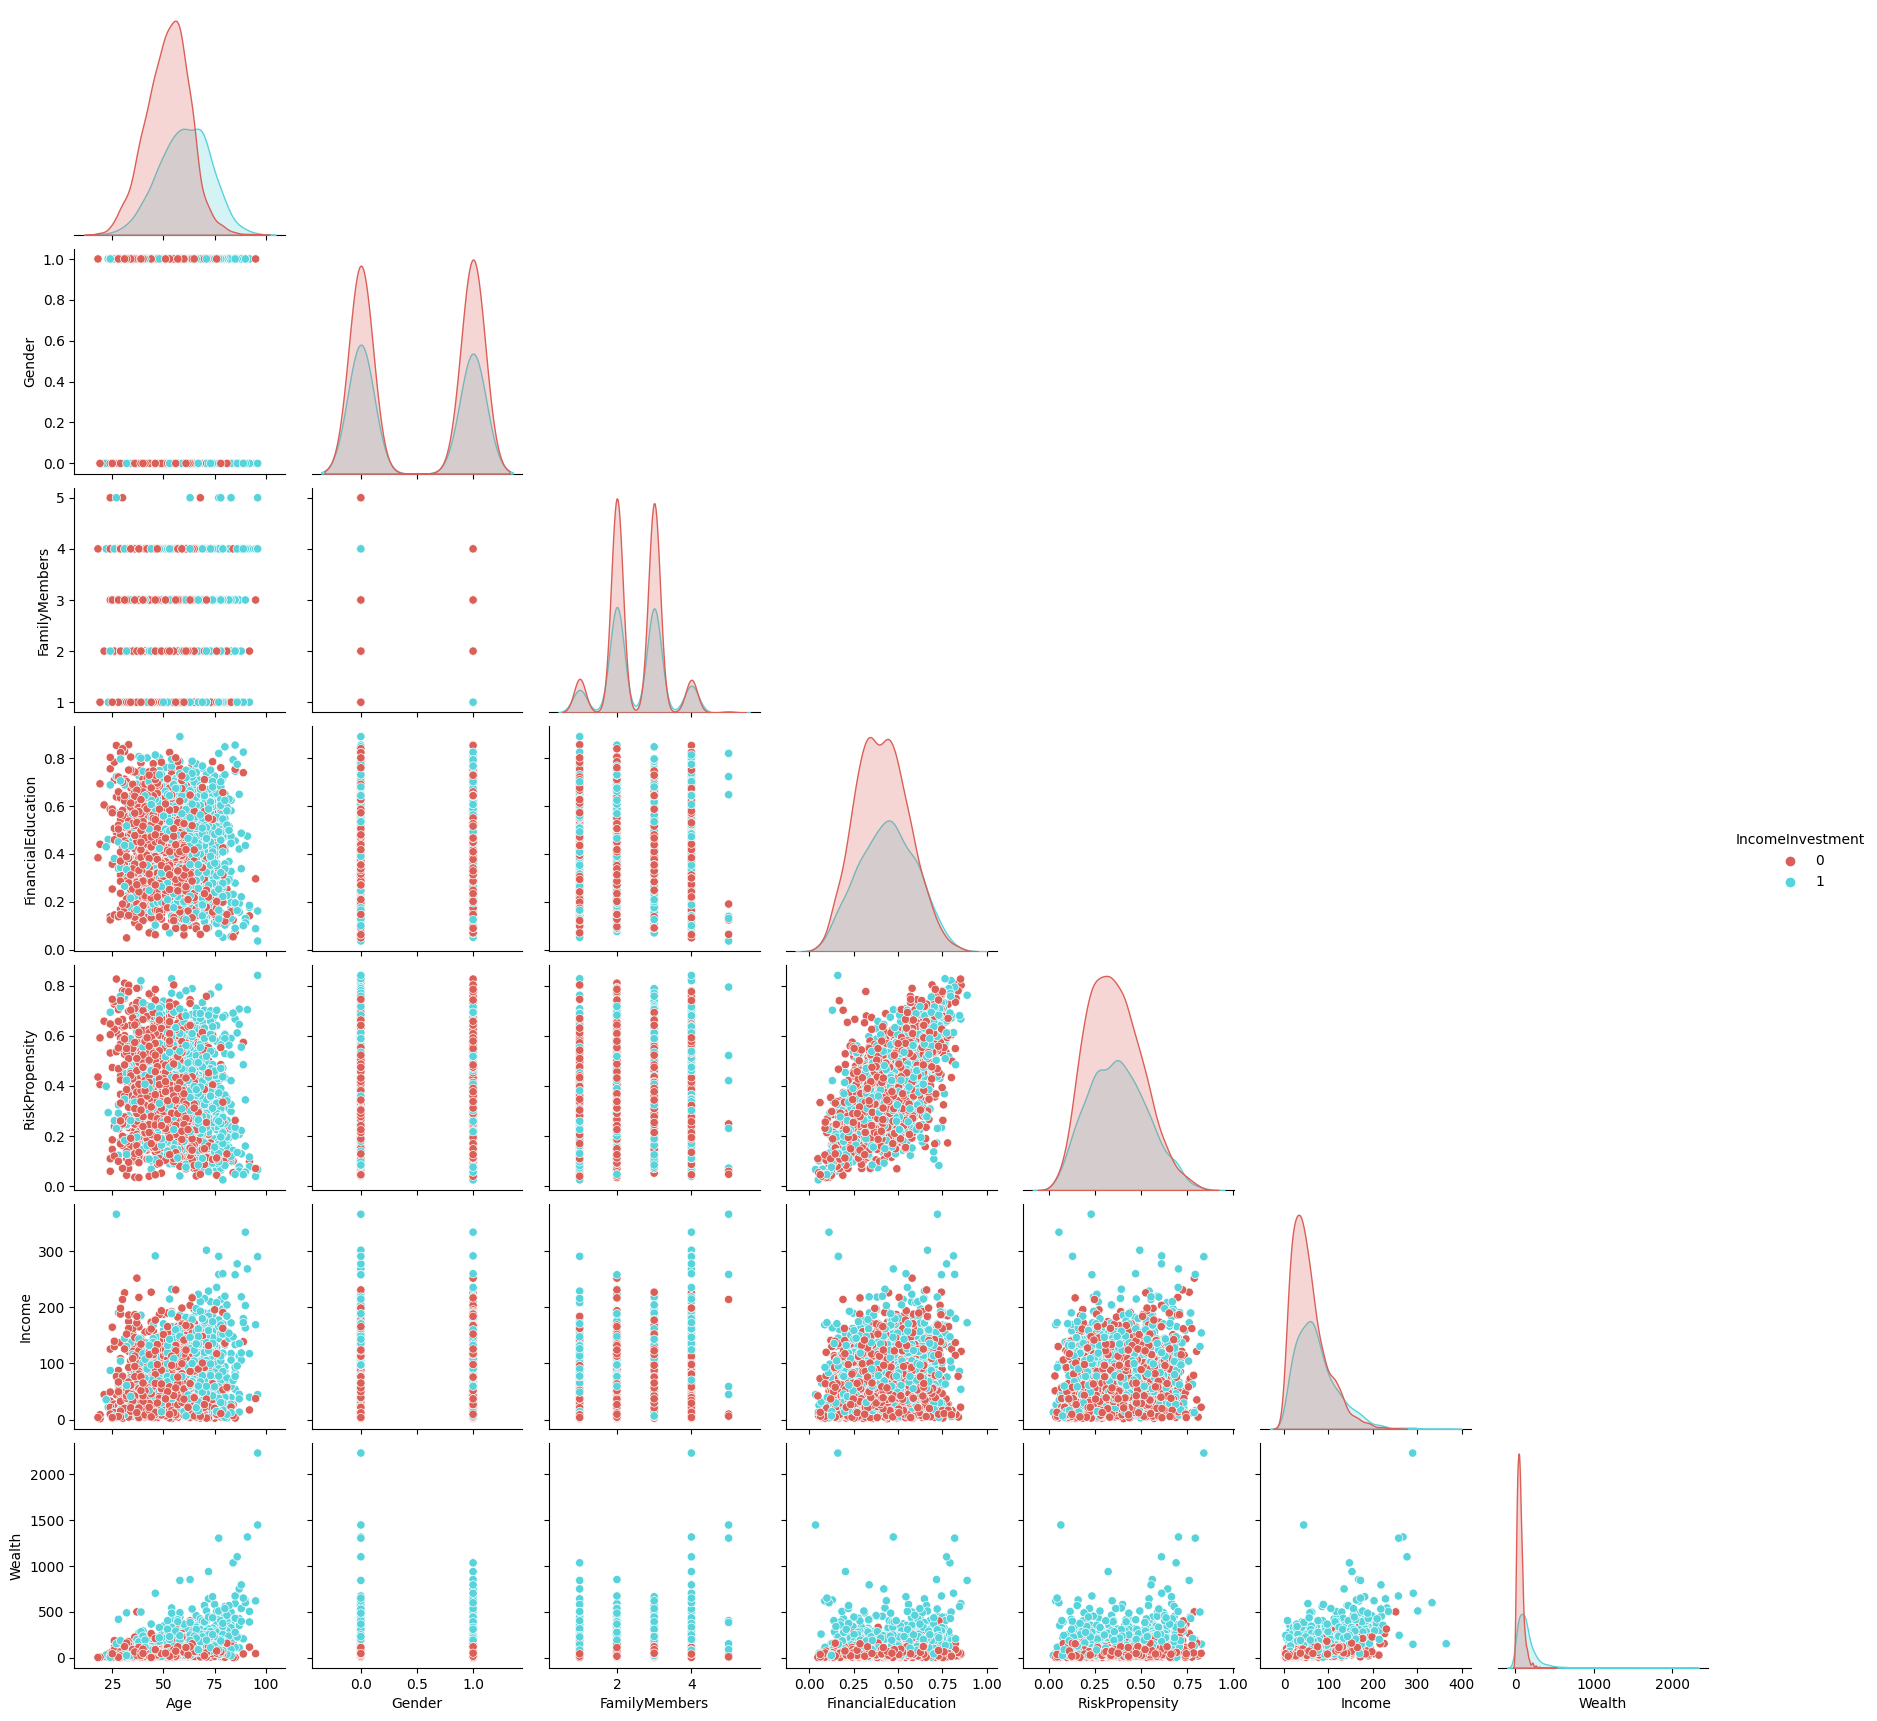

In [53]:
colour = sns.color_palette("hls", 2)
_ = sns.pairplot(pd.concat([x_train, y_inc_train], axis = 1), 
             hue= 'IncomeInvestment', 
             corner = True, 
             palette = colour, 
             vars = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth'])

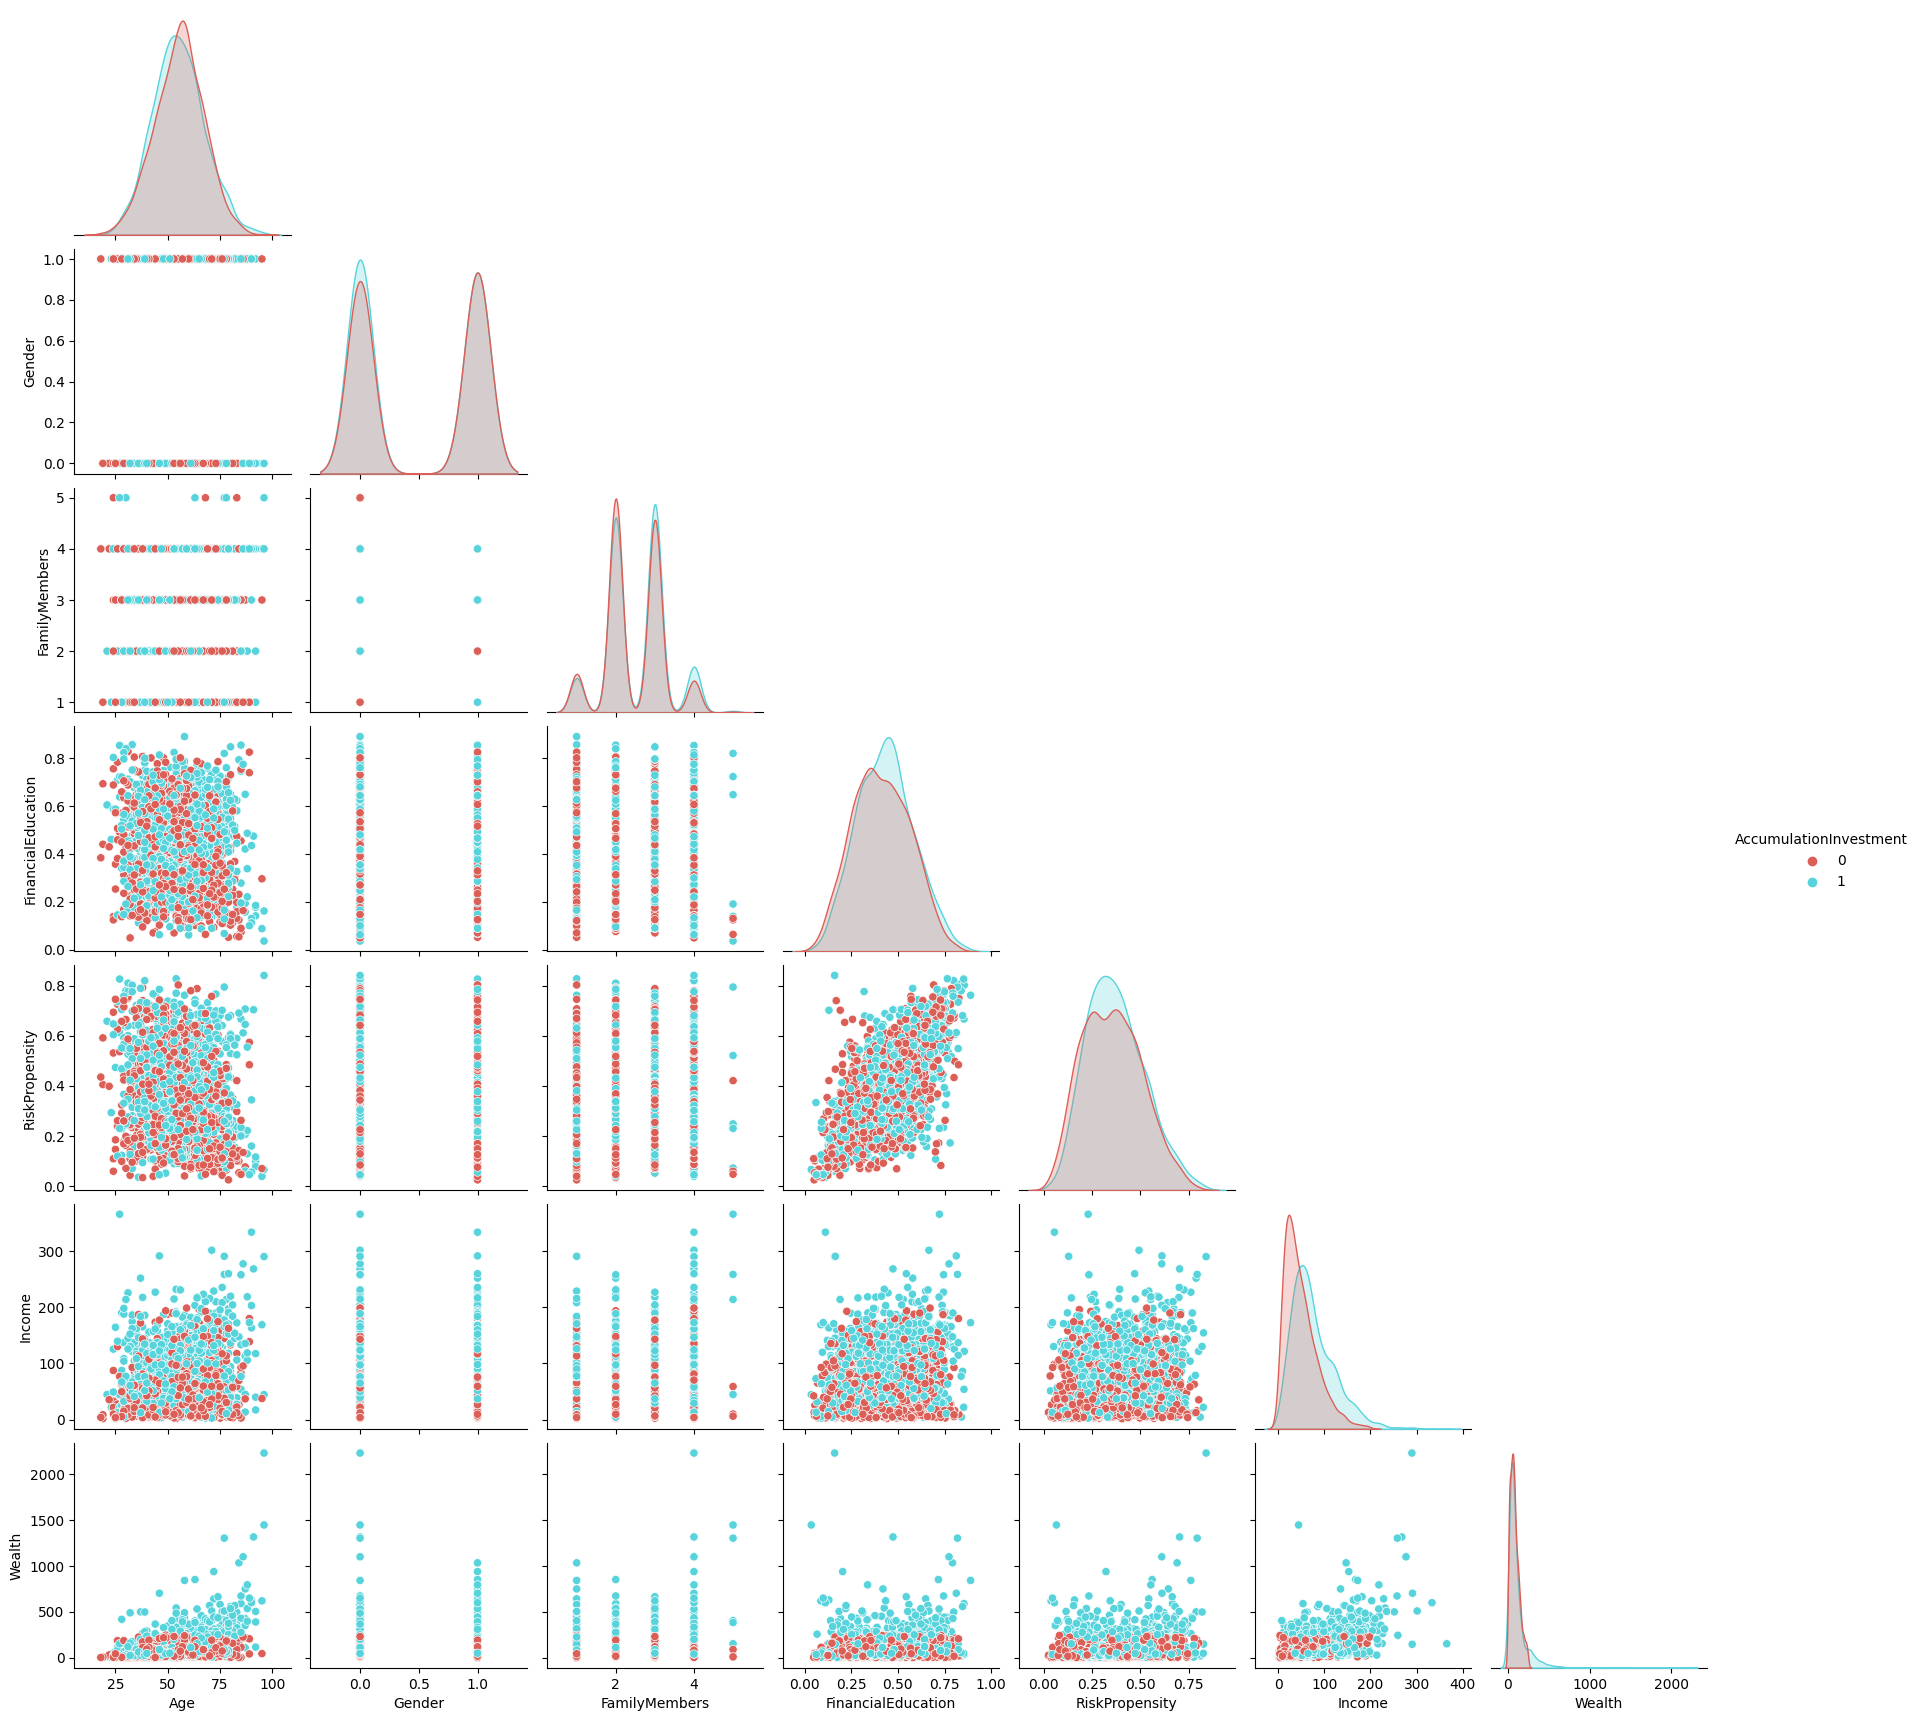

In [54]:
colour = sns.color_palette("hls", 2)
_ = sns.pairplot(pd.concat([x_train, y_acc_train], axis = 1), 
             hue= 'AccumulationInvestment', 
             corner = True, 
             palette = colour, 
             vars = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth'])

<code>Considerazioni sui plots (gender e 'forse' famiglia possono essere eliminati)</code>

# Data preprocessing

<code>Gender</code> feature is dropped since it showed no relevance in data exploration.

In [5]:
for x in [x_train, x_val, x_test]:
    x.drop(labels='Gender', axis=1, inplace=True)

Data exploration showed that <code>Wealth</code> and <code>Income</code> features are not gaussian distributed. A power law transformation is applied in order to modify the distribution related to these features. $0.1$ and $0.3$ values showed to work well in the two cases (transformed features are approximately gaussian distributed).

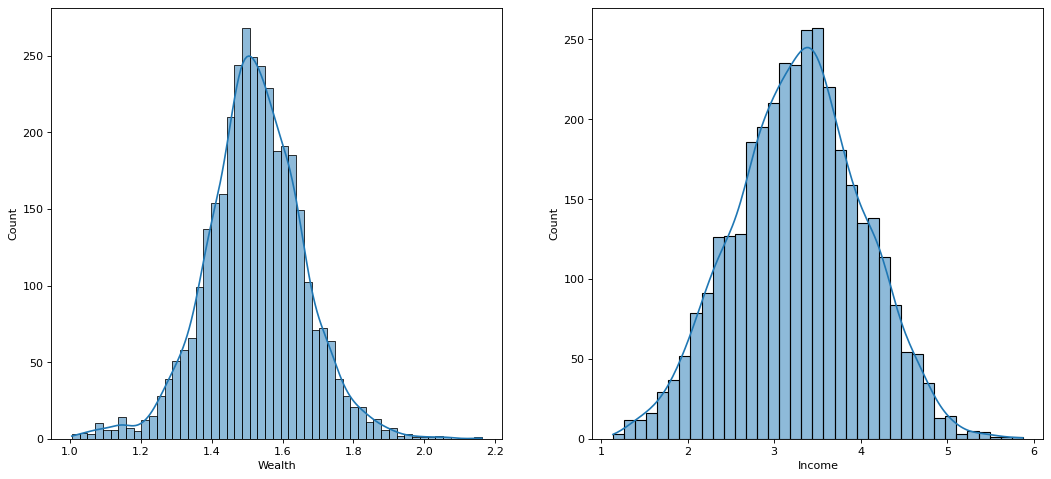

In [6]:
wealth_power = 0.1
income_power = 0.3

for x in [x_train, x_val, x_test]:
    x['Wealth'] = x['Wealth']**wealth_power
    x['Income'] = x['Income']**income_power

fig, axes = plt.subplots(1, 2, figsize=(16,7), dpi=80)
_ = sns.histplot(data=x_train, x='Wealth', ax=axes[0], kde=True)
_ = sns.histplot(data=x_train, x='Income', ax=axes[1], kde=True)

Standardization ($\mu =0\text{, }\sigma ^2=1$) is applied feature-wise to the dataframe. Mean and standard deviation values (evaluated on training set) are stored since they may be useful later to transform back to the original values.

In [7]:
features = x_train.columns
indexes = np.arange(len(features))

means = np.empty(len(features))
stds = np.empty(len(features))

for f, i in zip(features, indexes):
    means[i] = np.mean(x_train[f])
    stds[i] = np.std(x_train[f])
    for x in [x_train, x_val, x_test]:
        x[f] = (x[f] - means[i]) / stds[i]

# Classification

## First model: logistic regression

<code>Verificare perché non funziona la regularization con la logistic regression!</code> (escono gli stessi risultati con e senza regularization)

Logistic regression is used as first classification model. Two different classifiers are trained for <code>income investment propensity</code> and <code>accumulation investment propensity</code>.

In [9]:
from sklearn.linear_model import LogisticRegression

# defining the logistic regression object
log_reg = LogisticRegression(penalty='l2')

# fitting for income investment
log_reg.fit(x_train, y_inc_train)
y_inc_pred = log_reg.predict(x_val)

# fitting for accumulation investment
log_reg.fit(x_train, y_acc_train)
y_acc_pred = log_reg.predict(x_val)

### Results visualization

Confusion matrix and metrics are plotted.

Income Investment Propensity metrics:
Accuracy:	0.781
Recall:		0.611
Precision:	0.737
F1score:	0.668


Accumulation Investment Propensity metrics:
Accuracy:	0.664
Recall:		0.703
Precision:	0.669
F1score:	0.686




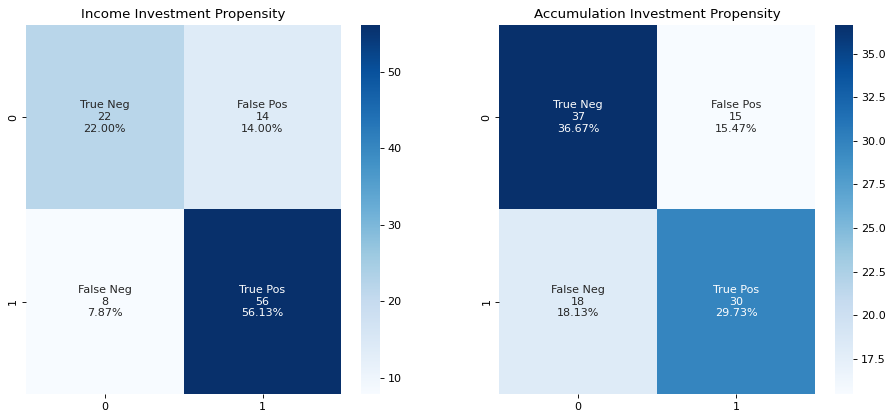

In [10]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)
title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

for y_val, y_pred, i in zip([y_inc_val, y_acc_val], [y_inc_pred, y_acc_pred], [0, 1]):

    cf_matrix = (confusion_matrix(y_val, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(title[i])

    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_val, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_val, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_val, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_val, y_pred):.3f}')
    print('\n')

<code>Commenti sui risultati ottenuti dal primo modello</code>

## Feature Engineering

In [19]:
# dropping risk pronensity feature since we only want to use it later
# for x in [x_train, x_val, x_test]:
#   x.drop('RiskPropensity', axis = 1)

Normalization and power transformation are reversed before creating <code>wealth/income</code> variable and plotting it.

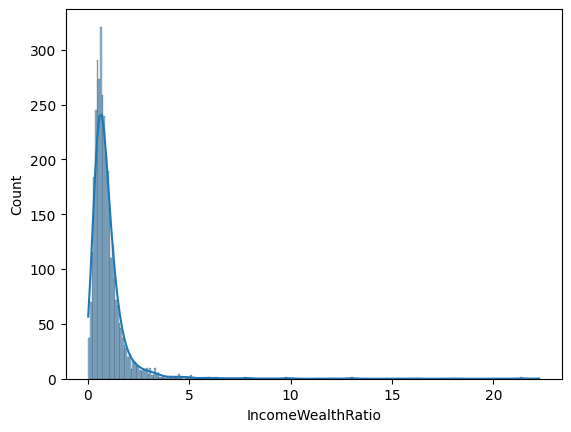

In [8]:
for f, i in zip(features, indexes):
    for x in [x_train, x_val, x_test]:
        x[f] = x[f] * stds[i] + means[i]

for x in [x_train, x_val, x_test]:
    x['Wealth'] = x['Wealth']**(1.0/wealth_power)
    x['Income'] = x['Income']**(1.0/income_power)
    x['IncomeWealthRatio'] = x['Income'] / x['Wealth']

_ = sns.histplot(data=x_train, x='IncomeWealthRatio', kde=True)

The power transformation is applied to <code>wealth/income</code> variable to modify its distribution to gaussian-like.

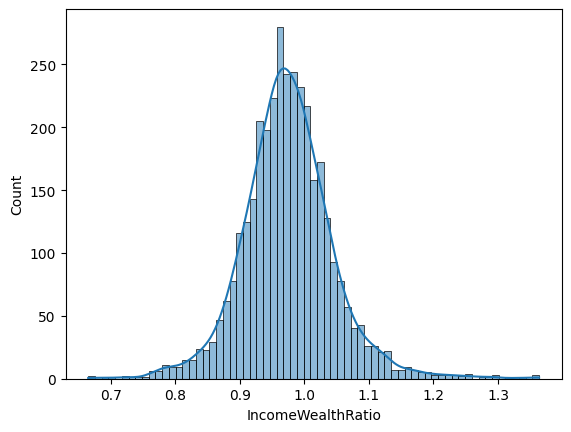

In [9]:
wealth_income_power = 0.1

for x in [x_train, x_val, x_test]:
    x['IncomeWealthRatio'] = x['IncomeWealthRatio']**wealth_income_power
    
_ = sns.histplot(data=x_train, x='IncomeWealthRatio', kde=True)

The data preprocessing already discussed above is re-applied to data in order to prepare it for classification.

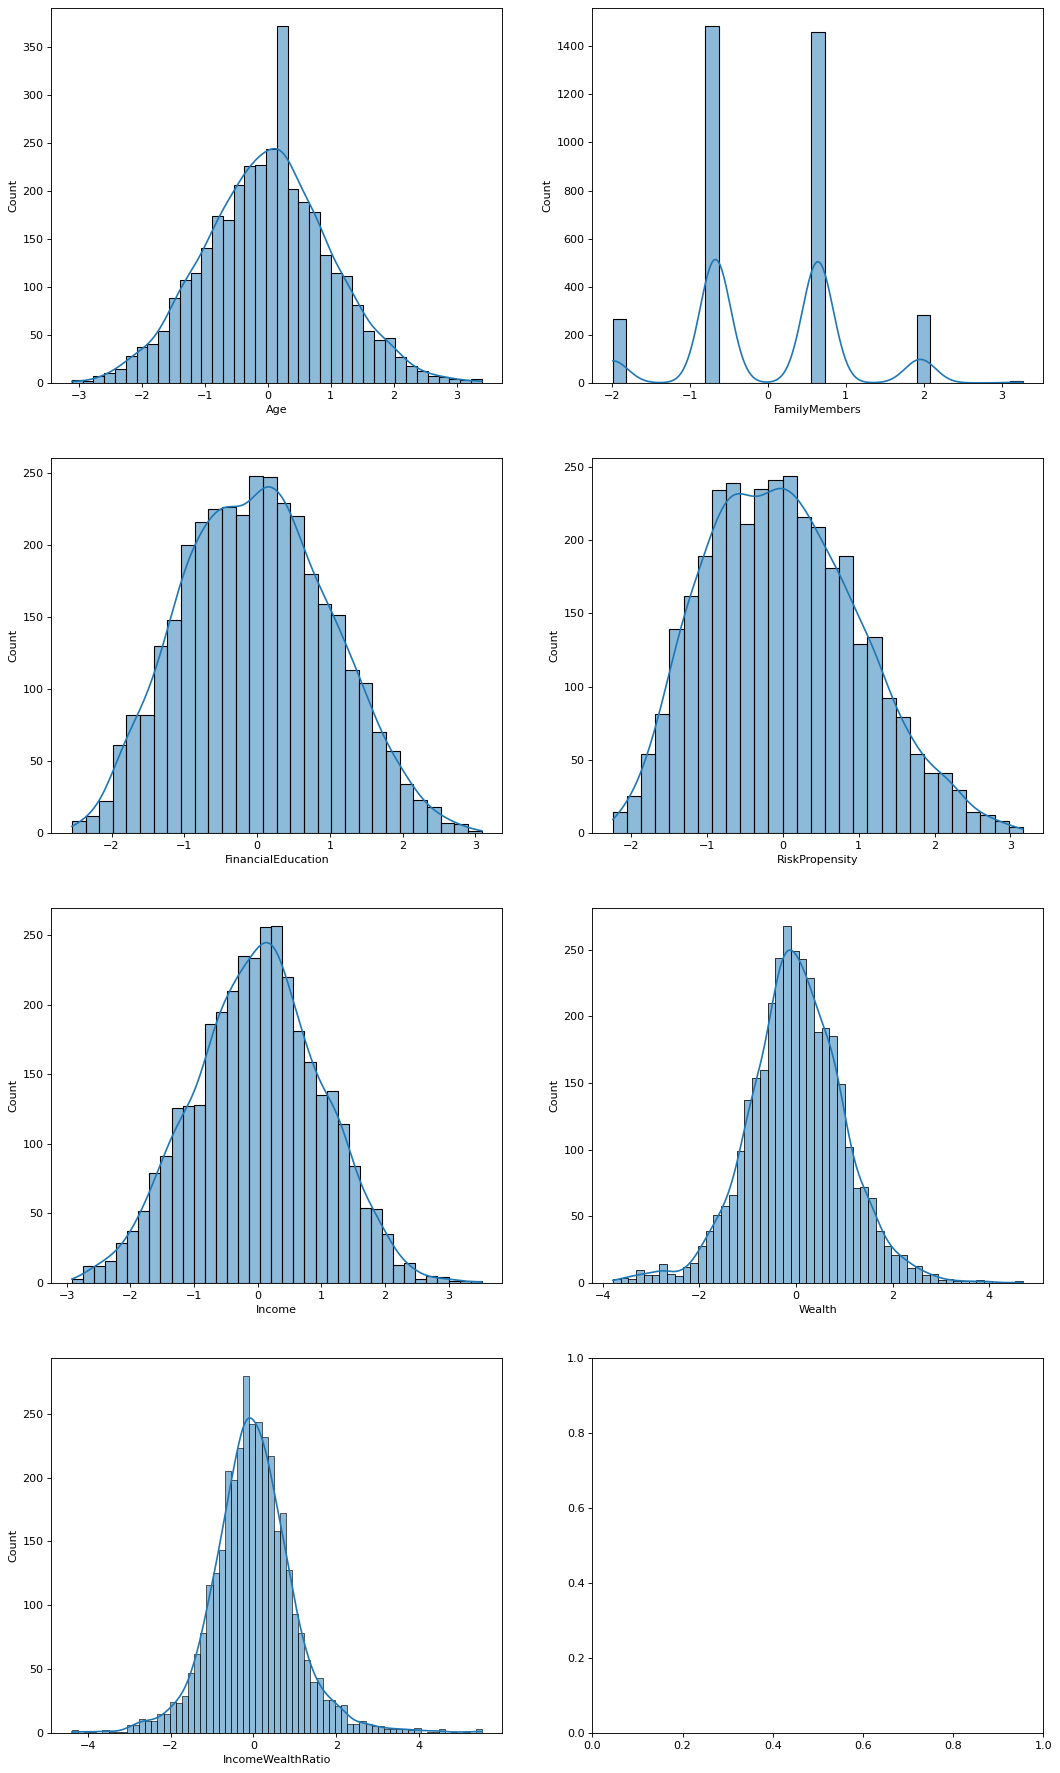

In [10]:
for x in [x_train, x_val, x_test]:
    x['Wealth'] = x['Wealth']**wealth_power
    x['Income'] = x['Income']**income_power

features = x_train.columns
indexes = np.arange(len(features))

means = np.empty(len(features))
stds = np.empty(len(features))

for f, i in zip(features, indexes):
    means[i] = np.mean(x_train[f])
    stds[i] = np.std(x_train[f])
    for x in [x_train, x_val, x_test]:
        x[f] = (x[f] - means[i]) / stds[i]

fig, axes = plt.subplots(4, 2, figsize=(16,28), dpi=80)
row = column = 0

for f in features:
    ax = axes[row][column]

    sns.histplot(data=x_train, x=f, ax=ax, kde=True)

    column = column + 1
    if column % 2 == 0:
        column = 0
        row = row + 1 

## Second model: logistic regression with new features

Logistic regression is fitted again on new training data.

In [14]:
# defining the logistic regression object
log_reg = LogisticRegression(penalty='l2')

# fitting for income investment
log_reg.fit(x_train, y_inc_train)
y_inc_pred = log_reg.predict(x_val)

# fitting for accumulation investment
log_reg.fit(x_train, y_acc_train)
y_acc_pred = log_reg.predict(x_val)

Income Investment Propensity metrics:
Accuracy:	0.785
Recall:		0.604
Precision:	0.751
F1score:	0.669



Accumulation Investment Propensity metrics:
Accuracy:	0.665
Recall:		0.714
Precision:	0.667
F1score:	0.690





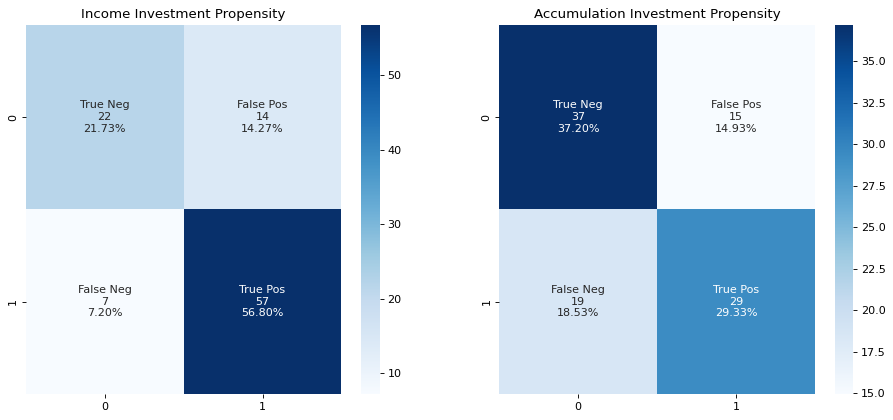

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)
title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

for y_val, y_pred, i in zip([y_inc_val, y_acc_val], [y_inc_pred, y_acc_pred], [0, 1]):

    cf_matrix = (confusion_matrix(y_val, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(title[i])

    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_val, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_val, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_val, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_val, y_pred):.3f}')
    print('\n\n')

<code>Commento sui risultati di questo secondo modello</code>

## Random forest

Random forest classifier

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

criterion_list = ['gini', 'entropy']
max_depth_list = [10, 12, 14]
n_estimators_list = [25, 75, 125]
min_samples_split_list = [2, 6, 10]

best_criterion = ['', '']
best_max_depth = ['', '']
best_n_estimators = ['', '']
best_min_samples_split = ['', '']

title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

for y_train, y_val, i in zip([y_inc_train, y_acc_train], [y_inc_val, y_acc_val], [0, 1]):

    f1 = 0

    for criterion in criterion_list:
        for max_depth in max_depth_list:
            for n_estimators in n_estimators_list:
                for min_samples_split in min_samples_split_list:

                    rand_forest = RandomForestClassifier(n_estimators = n_estimators, 
                                                         min_samples_split = min_samples_split,
                                                         criterion = criterion, 
                                                         random_state = seed, 
                                                         max_depth = max_depth)
                    rand_forest.fit(x_train, y_train)
                    y_pred = rand_forest.predict(x_val)

                    if(f1_score(y_val, y_pred) > f1):
                        best_criterion[i] = criterion
                        best_max_depth[i] = max_depth
                        best_n_estimators[i] = n_estimators
                        best_min_samples_split[i] = min_samples_split
                        f1 = f1_score(y_val, y_pred)

    print(title[i])
    print(f'Best criterion:\t{best_criterion[i]}')
    print(f'Best max_depth:\t{best_max_depth[i]}')
    print(f'Best n_estimators:\t{best_n_estimators[i]}')
    print(f'Best min_samples_split:\t{best_min_samples_split[i]}')
    print(f'F1score:\t{f1}')
    print('\n')


Income Investment Propensity
Best criterion:	gini
Best max_depth:	14
Best n_estimators:	25
Best min_samples_split:	10
F1score:	0.7145969498910675


Accumulation Investment Propensity
Best criterion:	entropy
Best max_depth:	12
Best n_estimators:	125
Best min_samples_split:	2
F1score:	0.8333333333333334




Income Investment Propensity metrics:
Accuracy:	0.825
Recall:		0.607
Precision:	0.868
F1score:	0.715


Accumulation Investment Propensity metrics:
Accuracy:	0.843
Recall:		0.754
Precision:	0.931
F1score:	0.833




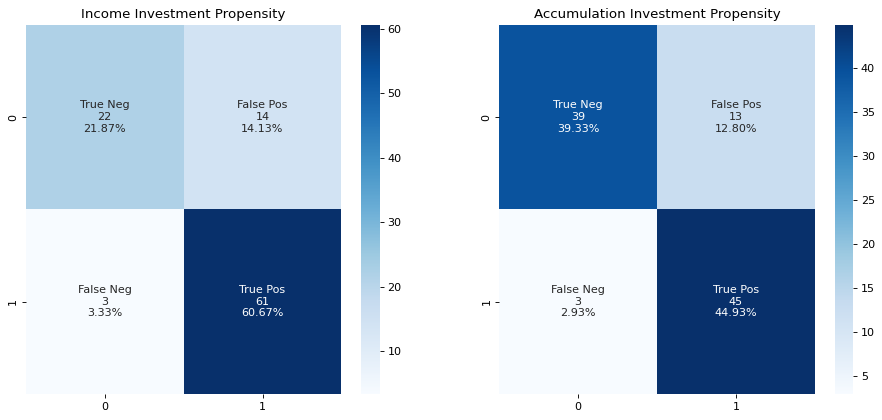

In [15]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)
title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

for y_train, y_val, i in zip([y_inc_train, y_acc_train], [y_inc_val, y_acc_val], [0, 1]):

    rand_forest = RandomForestClassifier(n_estimators = best_n_estimators[i], 
                                         min_samples_split = best_min_samples_split[i],
                                         criterion = best_criterion[i], 
                                         random_state = seed, 
                                         max_depth = best_max_depth[i])
    rand_forest.fit(x_train, y_train)
    y_pred = rand_forest.predict(x_val)

    cf_matrix = (confusion_matrix(y_val, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(title[i])

    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_val, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_val, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_val, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_val, y_pred):.3f}')
    print('\n')

# Recommendation system

The products list is read from the excel file.

In [16]:
products = pd.read_excel('Needs.xls', 'Products')

The products list is split between <code>income_products</code> and <code>accumulation_products</code>.

In [17]:
income_products = products[products['Type'] == 1]
accumulation_products = products[products['Type'] == 0]

The products are sorted in increasing <code>Risk</code> order.

In [18]:
income_products.sort_values('Risk', axis = 0, inplace=True)
accumulation_products.sort_values('Risk', axis = 0, inplace=True)

The minimum and maximum <code>RiskPropensity</code> values are inspected from the dataset in order to establish lower and upper bouds.

In [19]:
max_risk = np.max(df['RiskPropensity'])
min_risk = np.min(df['RiskPropensity'])
print(f'max risk = {max_risk:.3f}')
print(f'min risk = {min_risk:.3f}')

max risk = 0.883
min risk = 0.025


Adding <code>MinRisk</code> and <code>MaxRisk</code> columns to the products dataframes which will be used to assign products to clients.

In [20]:
for df in [income_products, accumulation_products]:

    lower_bound = []
    upper_bound = []

    for i in range(len(df['Risk'])):
        if (i==0):
            lower_bound.append(min_risk)
            upper_bound.append((df.iloc[i]['Risk'] + df.iloc[i+1]['Risk']) / 2.0)
        elif (i==len(df['Risk'])-1):
            lower_bound.append((df.iloc[i]['Risk'] + df.iloc[i-1]['Risk']) / 2.0)
            upper_bound.append(max_risk)
        else:
            lower_bound.append((df.iloc[i]['Risk'] + df.iloc[i-1]['Risk']) / 2.0)
            upper_bound.append((df.iloc[i]['Risk'] + df.iloc[i+1]['Risk']) / 2.0)

    df['MinRisk'] = lower_bound
    df['MaxRisk'] = upper_bound

Using on the risk values the same normalization used on <code>RiskPropensity</code> feature of the training set.

In [24]:
features = list(x_train.columns)
risk_index = features.index('RiskPropensity')
risk_columns = ['Risk', 'MinRisk', 'MaxRisk']

for df in [income_products, accumulation_products]:
    for r in risk_columns:
        df[r] = (df[r] - means[risk_index]) / stds[risk_index]

In [25]:
print(income_products)
print('\n')
print(accumulation_products)

    IDProduct  Type      Risk   MinRisk   MaxRisk
8           9     1 -0.616363 -2.240149 -0.318372
5           6     1 -0.020381 -0.318372  0.145169
4           5     1  0.310720  0.145169  0.542490
7           8     1  0.774261  0.542490  1.006031
0           1     1  1.237802  1.006031  1.900004
6           7     1  2.562205  1.900004  2.992637
10         11     1  3.423068  2.992637  3.441009


   IDProduct  Type      Risk   MinRisk   MaxRisk
2          3     0 -1.609666 -2.240149 -1.576556
9         10     0 -1.543445 -1.576556 -0.980574
1          2     0 -0.417702 -0.980574  0.045839
3          4     0  0.509380  0.045839  3.441009


Defining the two classifiers for <code>income investment propensity</code> and <code>accumulation investment propensity</code>.

In [26]:
income_classifier = RandomForestClassifier(n_estimators = best_n_estimators[0], 
                                           min_samples_split = best_min_samples_split[0],
                                           criterion = best_criterion[0], 
                                           random_state = seed, 
                                           max_depth = best_max_depth[0])
_ = income_classifier.fit(x_train, y_inc_train)

accumulation_classifier = RandomForestClassifier(n_estimators = best_n_estimators[1], 
                                                 min_samples_split = best_min_samples_split[1],
                                                 criterion = best_criterion[1], 
                                                 random_state = seed, 
                                                 max_depth = best_max_depth[1])
_ = accumulation_classifier.fit(x_train, y_acc_train)

The function that assigns the best product to a client given the classifiers and the products dataframes is defined.

In [27]:
def assign_product(client, income_classifier, accumulation_classifier, income_products, accumulation_products):

    # with [:,1] I pick the probability of the client to have the prediction = 1
    inc_pred = income_classifier.predict_proba(client)[:,1]
    acc_pred = accumulation_classifier.predict_proba(client)[:,1]
    client_risk = client.iloc[0]['RiskPropensity']
    
    # if inc_pred > acc_pred then the client is more inclined towards income investments -> income product
    if (inc_pred >= acc_pred):
        for i in range(len(income_products['IDProduct'])):
            if (client_risk >= income_products.iloc[i]['MinRisk'] and client_risk <= income_products.iloc[i]['MaxRisk']):
                return income_products.iloc[i]['IDProduct']
    else:
        for i in range(len(accumulation_products['IDProduct'])):
            if (client_risk >= accumulation_products.iloc[i]['MinRisk'] and client_risk <= accumulation_products.iloc[i]['MaxRisk']):
                return accumulation_products.iloc[i]['IDProduct']

Defining the product dictionary

In [29]:
products = {1.0: 'Balanced Mutual Fund',
            2.0: 'Income Conservative Unit-Linked (Life Insurance)',
            3.0: 'Fixed Income Mutual Fund',
            4.0: 'Balanced High Dividend Mutual Fund',
            5.0: 'Balanced Mutual Fund',
            6.0: 'Defensive Flexible Allocation Unit-Linked (Life Insurance)',
            7.0: 'Aggressive Flexible Allocation Unit-Linked (Life Insurance)',
            8.0: 'Balanced Flexible Allocation Unit-Linkled (Life Insurance)',
            9.0: 'Cautious Allocation Segregated Account',
            10.0: 'Fixed Income Segregated Account',
            11.0: 'Total Return Aggressive Allocation Segregated Account'}

In [31]:
print(products[assign_product(client = x_train.head(1), 
                              income_classifier = income_classifier,
                              accumulation_classifier = accumulation_classifier,
                              income_products = income_products,
                              accumulation_products = accumulation_products)])

Income Conservative Unit-Linked (Life Insurance)
